In [40]:
# import paket yang dibutuhkan
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D, Conv2D,AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [41]:
# inisialisasi Epoch dan Batch Size
INIT_LR = 1e-4
EPOCHS = 10
BS = 64

In [42]:
#import dataset
DIRECTORY = r"C:\Users\rivan\PycharmProjects\Bismillah_Skripsi\dataset_facemask"
CATEGORIES = ["WithMask", "WithoutMask"]

In [43]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
# 		dirubah menjadi 224x224
    	image = load_img(img_path, target_size=(224, 224))
		# gambar dirubah ke array agar dapat di normalisasi
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.082353   -0.8352941  -0.7882353 ]
  [ 0.082353   -0.8352941  -0.7882353 ]
  [ 0.00392163 -0.81960785 -0.78039217]
  ...
  [ 0.4901961   0.4901961   0.5058824 ]
  [ 0.41960788  0.41176474  0.45098042]
  [ 0.41960788  0.41176474  0.45098042]]

 [[ 0.082353   -0.8352941  -0.7882353 ]
  [ 0.082353   -0.8352941  -0.7882353 ]
  [ 0.00392163 -0.81960785 -0.78039217]
  ...
  [ 0.4901961   0.4901961   0.5058824 ]
  [ 0.41960788  0.41176474  0.45098042]
  [ 0.41960788  0.41176474  0.45098042]]

 [[ 0.09019613 -0.827451   -0.78039217]
  [ 0.09019613 -0.827451   -0.78039217]
  [ 0.03529418 -0.7882353  -0.7490196 ]
  ...
  [ 0.4901961   0.4901961   0.5058824 ]
  [ 0.45098042  0.4431373   0.48235297]
  [ 0.45098042  0.4431373   0.48235297]]

 ...

 [[ 0.39607847  0.39607847  0.41176474]
  [ 0.39607847  0.39607847  0.41176474]
  [ 0.39607847  0.39607847  0.41176474]
  ...
  [ 0.45882356  0.45098042  0.4901961 ]
  [ 0.48235297  0.48235297  0.49803925]
  [ 0.48235297  0.48235297  0.49803925]]

 [

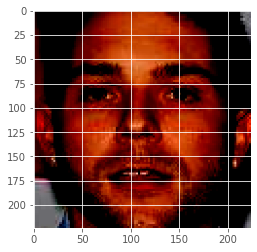

In [44]:
plt.imshow(image)
print(image)

In [45]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [46]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [47]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# IMG_SHAPE=(224,224,3)
# baseModel = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,
#                                              weights="imagenet")
# baseModel.trainable=False

In [48]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [49]:
baseModel.trainable = False
# baseModel.summary()

In [50]:
print("Building model with", baseModel)
model = tf.keras.Sequential([
    baseModel,
   
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', strides=1, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.MaxPooling2D(strides=1),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(2, activation='softmax')

])
# model = tf.keras.Sequential([
#     baseModel,
   
#     tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', strides=1, activation='relu'),
#     tf.keras.layers.MaxPooling2D(strides=1),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(rate=0.5),
#     tf.keras.layers.Dense(2, activation='softmax')

# ])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics='accuracy'
             )

model.summary()

Building model with <tensorflow.python.keras.engine.functional.Functional object at 0x000001EC62C1FD88>
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1026      
Total params: 2,

In [51]:


# # construct the head of the model that will be placed on top of the
# # the base model
# headModel = baseModel.output
# headmodel = Conv2D(32, 3, activation='relu')(headModel)
# headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(2, activation="softmax")(headModel)
# # place the head FC model on top of the base model (this will become
# # the actual model we will train)

# model = Model(inputs=baseModel.input, outputs=headModel)

# # model = tf.keras.Sequential([
# #     baseModel,
# #     tf.keras.layers.Conv2D(32,3,activation='relu'),
# #     tf.keras.GlobalAveragePooling2D(),
# #     tf.keras.Flatten(name="flatten"),
# #     tf.keras.Dense(128, activation="relu"),
# #     tf.keras.Dropout(0.5),
# #     tf.keras.Dense(2, activation="softmax")
# # ])
# # loop over all layers in the base model and freeze them so they will
# # *not* be updated during the first training process
# for layer in baseModel.layers:
# 	layer.trainable = False



In [52]:
# compile our model
# print("[INFO] compiling model...")
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# model.compile(loss="categorical_crossentropy", optimizer=opt,
# 	metrics=["accuracy"])

model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics='accuracy')


In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1026      
Total params: 2,627,682
Trainable params: 369,698
Non-trainable params: 2,257,984
______________________________________

In [54]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)



# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("deteksi_masker_fix.model", save_format="h5")


[INFO] training head...
Epoch 1/10
125/125 [==============================] - 174s 1s/step - loss: 0.1493 - accuracy: 0.9632 - val_loss: 0.0239 - val_accuracy: 0.9925
Epoch 2/10
125/125 [==============================] - 179s 1s/step - loss: 0.0452 - accuracy: 0.9849 - val_loss: 0.0242 - val_accuracy: 0.9915
Epoch 3/10
125/125 [==============================] - 180s 1s/step - loss: 0.0397 - accuracy: 0.9865 - val_loss: 0.0667 - val_accuracy: 0.9780
Epoch 4/10
125/125 [==============================] - 180s 1s/step - loss: 0.0831 - accuracy: 0.9762 - val_loss: 0.0327 - val_accuracy: 0.9895
Epoch 5/10
125/125 [==============================] - 180s 1s/step - loss: 0.0325 - accuracy: 0.9891 - val_loss: 0.0264 - val_accuracy: 0.9935
Epoch 6/10
125/125 [==============================] - 182s 1s/step - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.0212 - val_accuracy: 0.9920
Epoch 7/10
125/125 [==============================] - 182s 1s/step - loss: 0.0269 - accuracy: 0.9912 - val_loss: 0.015

C:\Users\rivan\anaconda3\envs\rivan_skripsi\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [55]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

    WithMask       1.00      0.99      0.99      1000
 WithoutMask       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



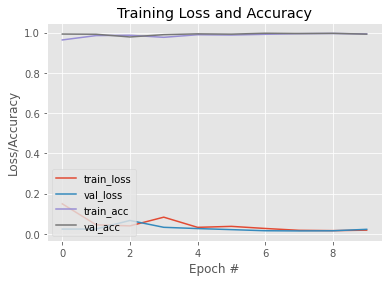

In [56]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plotData.png")